# Setup

### Initial tasks

In [59]:
# allow multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# suppress warnings
import sys, os, warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# also suppress warnings of parallel processes such as grid search cv
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

### Imports

In [60]:
# built-ins
import os
import json
import math
import time
import pickle
import traceback
from os import path
from pathlib import Path
from datetime import datetime
from itertools import combinations

# common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# misc
from IPython.display import display, clear_output, Markdown
from termcolor import colored

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from scipy.stats import ttest_ind

# training
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### Utils / Helpers

In [61]:
def load_json(path):
    with open(path, encoding='utf-8') as f:
        return json.load(f)
    
def cprint(text, color):
    print(colored(text, color, attrs=['bold']))
    
def print_red(text):
    cprint(text, 'red')

def print_blue(text):
    cprint(text, 'blue')

In [62]:
class PrintDuration(object):
    class printer(str):
        def __repr__(self):
            return self
        
    def __enter__(self):
        self.start_time = datetime.now()
        self.last_tick = self.start_time
        self.tick_count = 0
        self.tick_times = 0
        
        self.completed = False
        self.progress = 0
        self.ert = 0
        self.att = 0
        self.out = None
        
        return self.tick
  
    def __exit__(self, exc_type, exc_value, tb):
        if exc_type is not None:
            traceback.print_exception(exc_type, exc_value, tb)
        
        self.completed = True
        self.render()
        
    def tdformat(self, seconds):
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return '{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds))
    
    def render(self):
        output = ''
        
        if self.completed:
            complete_time = (datetime.now() - self.start_time).total_seconds()
            complete_time = self.tdformat(complete_time)
            output = f'100% completed, total run time = {complete_time}'
        else:
            percent = round(self.progress * 100)
            att = self.tdformat(self.att)
            ert = self.tdformat(self.ert)
            output = f'{percent}% completed, remaining time = {ert}, avg ticktime = {att}'
        
        output = self.printer(output)
        
        if self.out is None:
            self.out = display(output, display_id=True)
        else:
            self.out.update(output)
    
    def tick(self, progress):
        now = datetime.now()
        
        # calculate
        work_time = (now - self.start_time).total_seconds()
        tick_time = (now - self.last_tick).total_seconds()
        self.tick_count += 1
        self.tick_times += tick_time
        avg_tick_time = self.tick_times // self.tick_count
        
        if progress > 0:
            total_ticks = self.tick_count // progress
            remained_ticks = total_ticks - self.tick_count
            est_remain_time = avg_tick_time * remained_ticks
        else:
            est_remain_time = 0
            
        # set
        self.progress = progress
        self.att = avg_tick_time
        self.ert = est_remain_time
        
        # render
        self.render()             

### Detect Env

In [63]:
ENV_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE') is not None

### Path Definitions

In [64]:
path_root = '.'
path_dataset = path.join(path_root, 'dataset')
path_csv = path.join(path_dataset, 'csv')
path_csv_output =  path_csv
path_models = path.join(path_root, 'models')

if ENV_KAGGLE:
    path_root = '/kaggle/working'
    path_dataset = '/kaggle/input/aihw2'
    path_csv = path.join(path_dataset, 'csv')
    path_csv_output = path_root
    path_models = path.join(path_root, 'models')
    
# Create directories.
Path(path_models).mkdir(parents=True, exist_ok=True)

### Configs

In [65]:
cfg_autosave_models = False
cfg_force_train = False

if ENV_KAGGLE:
    cfg_autosave_models = True
    cfg_force_train = False

# Hyperparameters

In [66]:
hp_seed = 7908
hp_cv_splits = 10
hp_test_size = 0.2

# Preprocessing

In [67]:
def map_employement_duration(entry):
    entry = str(entry).lower()
    split = entry.split(' ')
    num = split[0]
    output = entry
    
    if "-" in num:
        num = num.split("-")[1]
    
    if "weeks" in entry:
        output = float(num) / 52
    elif ("month" in entry) or ("ay" in entry):
        output = float(num) / 12
    elif ("years" in entry) or ("sene" in entry) or ("yıl" in entry):
        output = float(num)
    else:
        try:
            output = float(num)
        except:
            output = 0
        
    output = round(output, 3)
    return output

In [68]:
# read encodings
encodings = load_json(path.join(path_dataset, 'encodings.json'))

# read csvs
csv_en = pd.read_csv(path.join(path_csv, 'english.csv'), dtype=str, encoding='utf-8')
csv_tr = pd.read_csv(path.join(path_csv, 'turkish.csv'), dtype=str, encoding='utf-8')

# drop columns
csv_en.drop('Timestamp', axis=1, inplace=True)
csv_tr.drop('Timestamp', axis=1, inplace=True)

# rename columns
csv_en.rename(columns=encodings['columns']['en'], inplace=True)
csv_tr.rename(columns=encodings['columns']['tr'], inplace=True)

# encode columns
csv_en.replace(encodings['values']['en'], inplace=True)
csv_tr.replace(encodings['values']['tr'], inplace=True)

# concat csvs
df = pd.concat([csv_en, csv_tr], axis=0).reset_index(drop=True)

# fix NaNs
df.fillna(0, inplace=True)

# convert types
df['age'] = df['age'].apply(lambda x: int(x))
df['weight'] = df['weight'].apply(lambda x: int(float(x.replace(',', '.'))))
df['height'] = df['height'].apply(lambda x: int(x.translate({ord(x): '' for x in [',', '.', ' ']})))
df['employment_duration'] = df['employment_duration'].apply(map_employement_duration)

# save csv
df.to_csv(path.join(path_csv_output, 'data.csv'), index=None, header=True, encoding='utf-8-sig')

# initial feature selection
# drop employment_duration column since it has high correlation with age.
df.drop('employment_duration', axis=1, inplace=True)
df.info()

# separate data and labels
df_data = df.drop('weight', axis=1)
df_labels = df['weight']

# convert to numpy
data = df_data.to_numpy()
labels = df_labels.to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       322 non-null    int64
 1   height    322 non-null    int64
 2   weight    322 non-null    int64
 3   gender    322 non-null    int64
 4   smoking   322 non-null    int64
 5   drinking  322 non-null    int64
 6   exercise  322 non-null    int64
 7   married   322 non-null    int64
 8   children  322 non-null    int64
 9   student   322 non-null    int64
 10  employed  322 non-null    int64
dtypes: int64(11)
memory usage: 27.8 KB


In [70]:
df.head()

,age,height,weight,gender,smoking,drinking,exercise,married,children,student,employed
0,36,175,82,1,0,3,1,0,0,0,1
1,22,178,77,1,0,2,1,0,0,1,0
2,32,174,65,1,0,2,1,0,0,1,2
3,21,156,65,0,0,0,2,0,0,1,0
4,24,176,94,1,0,1,1,0,0,1,0


# Pipeline Setup

In [71]:
class Preprocessor:
    def __init__(self, scale=False, scale_columns=None, pca=False, pca_n=None):
        self.scale = scale
        self.pca = pca
        
        if self.scale or self.pca:
            self.scale_columns = scale_columns
            self.scaler = preprocessing.StandardScaler()
        
        if self.pca:
            self.pca_n = pca_n
            self.PCA = PCA(n_components=pca_n, svd_solver='full', copy=True)
    
    def fit(self, data):
        if self.pca:
            data = self.scaler.fit_transform(data)
            self.PCA.fit(data)
        elif self.scale:
            cols = self.scale_columns
            self.scaler.fit(data[:, cols])
        
    def transform(self, data):
        if self.pca:
            data = self.scaler.transform(data)
            data = self.PCA.transform(data)
        elif self.scale:
            cols = self.scale_columns
            data[:, cols] = self.scaler.transform(data[:, cols])
            
        return data

In [72]:
class Model:
    def __init__(self, estimator, data, labels, n_splits, test_size, seed,
                 prep_params={}, hp_grid=None):
        
        self.estimator = estimator
        self.data = data
        self.labels = labels
        self.n_splits = n_splits
        self.test_size = test_size
        self.seed = seed
        self.prep_params = prep_params
        self.hp_grid = hp_grid
        
        self.stats = []
        self.best_stats = None
        self.best_estimator = None
    
    def split(self):
        split = ShuffleSplit(n_splits=self.n_splits, test_size=self.test_size, random_state=self.seed)
        
        for train_index, test_index in split.split(self.data):
            train_data = (self.data[train_index], self.labels[train_index])
            test_data = (self.data[test_index], self.labels[test_index])

            yield(train_data, test_data)
    
    def train(self, tick=None):
        for split_index, (train_data, test_data) in enumerate(self.split()):
            if tick is not None:
                tick(split_index/self.n_splits)
            
            X_train, Y_train = train_data
            X_test, Y_test = test_data
            
            # create and use preprocessor
            preprocessor = Preprocessor(**self.prep_params)
            preprocessor.fit(X_train)
            X_train = preprocessor.transform(X_train)
            X_test = preprocessor.transform(X_test)
            
            estimator = self.estimator()
            
            # default values
            best_params = None
            best_estimator = estimator
            
            # fit estimator
            if self.hp_grid is not None:
                cv = GridSearchCV(estimator, self.hp_grid, cv=self.n_splits, n_jobs=-1)
                cv.fit(X_train, Y_train)
                
                best_params = cv.best_params_
                best_estimator = cv.best_estimator_
            else:
                best_estimator.fit(X_train, Y_train)
            
            Y_pred = best_estimator.predict(X_test)
            rsme = round(np.sqrt(mean_squared_error(Y_test, Y_pred)), 2)
            
            result = dict(y_true=Y_test, y_pred=Y_pred, best_params=best_params, rsme=rsme,
                          seed=self.seed, best_estimator=best_estimator, preprocessor=preprocessor)
            
            self.stats.append(result)
    
    def predict(self, data):
        data = data.copy()
        self.best_preprocessor.transform(data)
        return self.best_estimator.predict(data)
    
    def collect_best_stats(self):
        best_rsme = math.inf
        total_rsme = 0
        best_stats = None
        
        for stats in self.stats:
            rsme = stats['rsme']

            total_rsme += rsme
            if rsme < best_rsme:
                best_rsme = rsme
                best_stats = stats
        
        self.best_stats = best_stats
        self.best_estimator = best_stats['best_estimator']
        self.best_preprocessor = best_stats['preprocessor'] 
        self.mean_rsme = total_rsme / len(self.stats)

In [73]:
class Trainer:   
    def __init__(self, name, data, labels, n_splits, test_size, seed, prep_params={}):
        self.name = name
        self.data = data
        self.labels = labels
        self.n_splits = n_splits
        self.test_size = test_size
        self.seed = seed
        self.prep_params = prep_params
        self.estimators = {}
    
    def set_estimators(self, estimators):
        self.estimators = estimators
    
    def get_model_path(self, name):
        return path.join(path_models, f'{self.name}_{name}.pickle')
    
    def save_model(self, name, model):
        model_path = self.get_model_path(name)
        with open(model_path,'wb') as file:
            pickle.dump(model, file)
        
    def load_model(self, name):
        model_path = self.get_model_path(name)
        with open(model_path, 'rb') as file:
            return pickle.load(file)
        
    def train_estimators(self, **kwargs):
        estimators = kwargs.pop('estimators', self.estimators.keys())
        for name in estimators:
            print_red(f'Estimator: {name}\n')
            model = self.train_estimator(name, **kwargs)
            yield (name, model)
            
    def train_estimator(self, name, reset=False, seed=None, save=True):      
        if seed is None:
            seed = self.seed
        
        if not reset:
            try:
                model = self.load_model(name)
                setattr(self, name, model)
                
                print(f'Model {name} is loaded from disk successfully.')
                return model
            
            except:
                model = None
        
        name, estimator, hp_grid = self.estimators[name]
        model = Model(estimator, self.data, self.labels, self.n_splits,
                    self.test_size, seed, self.prep_params, hp_grid)
        
        with PrintDuration() as tick:
            model.train(tick)

        model.collect_best_stats()
        setattr(self, name, model)
        
        if save:
            self.save_model(name, model)
            
        return model
    
    def search_best_seed(self, name, seed_range=100):
        best_rsme = math.inf
        best_seed = 0

        for seed in range(seed_range):
            estimator = self.train_estimator(name, seed, save=False)
            rsme = estimator.best_stats["rsme"]

            if rsme < best_rsme:
                best_rsme = rsme
                best_seed = seed
                print(f'{seed} -> {rsme} - {estimator.mean_rsme}')
        
        print(f'Best seed found as {best_seed}')
        return best_seed
    
    def calculate_ttest(self, p=0.05):
        models = list(self.estimators.keys())
        scores = {m: [s['rsme'] for s in getattr(self, m).stats] for m in models}
        pairs = list(combinations(models, 2))

        ttests = []
        for a, b in pairs:
            t_val, p_val = ttest_ind(scores[a], scores[b])

            ttests.append({
                'models': [a, b], 't_val': abs(t_val),
                'p_val': p_val, 'significant': p_val <= p
            })

        significants = [t['models'] for t in ttests if t['significant']]
        non_significants = [t['models'] for t in ttests if not t['significant']]

        return significants, non_significants, ttests
    
    def get_results_dataframe(self, name, shuffle=False, ascending=False):
        model = getattr(self, name)

        true = model.best_stats['y_true'].reshape(-1)
        pred = model.best_stats['y_pred'].reshape(-1)
        
        df = pd.DataFrame(data={
            'true': true,
            'prediction': pred,
            'diff': np.absolute(true - pred)
        })
    
        if shuffle:
            df = df.sample(frac=1)
        else:
            df = df.sort_values('diff', ascending=ascending)
        
        return df
    
    def print_stats(self, name):
        model = getattr(self, name)
        print('best_rsme', model.best_stats['rsme'])
        print('mean_rsme', model.mean_rsme)
        print('best_params', model.best_stats['best_params'])

In [74]:
class SetTrainer:
    def __init__(self):
        self.estimators = {}
        self.trainer_names = []
        
    def add_estimator(self, name, estimator, hp_grid=None):
        self.estimators[name] = (name, estimator, hp_grid)
        
    def add_trainer(self, **kwargs):
        name = kwargs['name']
        trainer = Trainer(**kwargs)
        trainer.set_estimators(self.estimators)
        
        self.trainer_names.append(name)
        setattr(self, name, trainer)
        
    def run_trainer(self, name, **kwargs):
        trainer = getattr(self, name)
        for (model_name, model) in trainer.train_estimators(**kwargs):
            yield (name, trainer, model_name, model)
            
    def run_all_trainers(self, **kwargs):
        trainers = kwargs.pop('trainers', self.trainer_names)
        count = len(trainers)
        
        for index, name in enumerate(trainers):
            print_blue(f'Trainer {index+1}/{count}: {name}\n')
            for (trainer_name, trainer, model_name, model) in self.run_trainer(name, **kwargs):
                yield (trainer_name, trainer, model_name, model)
    
set_trainer = SetTrainer()

### Helper Functions

### Feature Importance

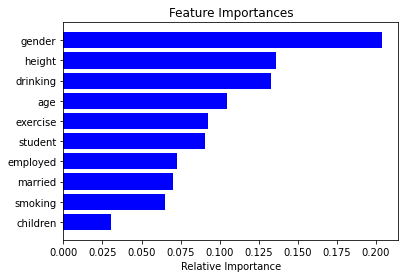

In [80]:
def calculate_feature_importances(data, labels, n_splits, test_size, seed, prep_params={}):
    model = Model(RandomForestRegressor, data, labels, n_splits, test_size, seed, prep_params)
    model.train()
    model.collect_best_stats()
    
    importances = model.best_estimator.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [df_data.columns.to_list()[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
calculate_feature_importances(data=data, labels=labels, n_splits=hp_cv_splits,
                              test_size=hp_test_size, seed=hp_seed,
                              prep_params={'scale':True, 'scale_columns':[0, 1]})

### Explained Variance Ratio

For p=99% n_components should be 10



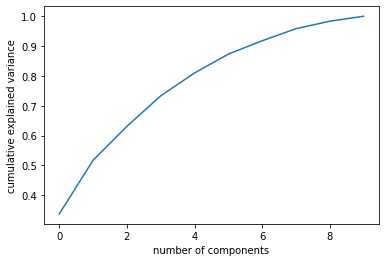

In [83]:
def calculate_explained_variance_ratio(data, p=0.95):
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(data)
    
    pca = PCA(n_components=None, svd_solver='full', copy=True)
    reduced = pca.fit_transform(X)
    
    # extract the smallest number of components which
    # explain at least p% (e.g. 80%) of the variance
    n_components = 1 + np.argmax(np.cumsum(pca.explained_variance_ratio_) >= p)
    print(f'For p={int(p*100)}% n_components should be {n_components}\n')

    # extract the values of the selected components
    #Z = pca.transform(X)[:, :n_components]
    
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    
calculate_explained_variance_ratio(data, 0.99)

# Model Definitions

## Linear Regression 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [84]:
# Add estimator
set_trainer.add_estimator('linear', LinearRegression, {
    'fit_intercept': [True, False],
    'positive': [False, True], 
})

## Support Vector Regression

[docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [85]:
# Add estimator
set_trainer.add_estimator('svr', SVR, {
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto'],
    'C': [1, 10, 100],
    'epsilon': [0.05, 0.1, 0.2]
})

## Bayesian Ridge

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html)

In [86]:
# Add estimator
set_trainer.add_estimator('br', BayesianRidge, {
    'n_iter': [300, 500, 700]
})

## kNN

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

In [87]:
# Add estimator
set_trainer.add_estimator('knn', KNeighborsRegressor, {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
})

## Decision Tree

[docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [88]:
# Add estimator
set_trainer.add_estimator('dt', DecisionTreeRegressor, {
    'criterion': ['squared_error', 'absolute_error'],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [1, 0.8, 0.5],
})

## Bagging

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html)

In [89]:
# Add estimator
set_trainer.add_estimator('bag', BaggingRegressor, {
    'n_estimators': [10, 20, 50],
    'max_samples': [1, 0.8, 0.5],
    'max_features': [1, 0.8, 0.5],
})

## Random Forest

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [90]:
# Add estimator
set_trainer.add_estimator('rf', RandomForestRegressor, {
    'n_estimators': [100, 200, 500],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2],
    'max_features': [1, 0.8, 0.5],
    'max_samples': [1, 0.8, 0.5],
})

## XGBoost

[doc](https://xgboost.readthedocs.io/en/stable/parameter.html)

In [91]:
# Add estimator
set_trainer.add_estimator('xgb', XGBRegressor, {
    'learning_rate': [0.1, 0.3, 0.5],
    'subsample': [0.5, 0.75, 1],
})

## AdaBoost

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)

In [92]:
# Add estimator
set_trainer.add_estimator('ada', AdaBoostClassifier, {
    'learning_rate': [0.3, 0.5, 1],
    'n_estimators': [50, 100, 200],
})

## LGBM

[doc](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [93]:
# Add estimator
set_trainer.add_estimator('lgbm', LGBMRegressor, {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
})

## MLP

[doc](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

In [94]:
# Add estimator
set_trainer.add_estimator('mlp', MLPRegressor, {
    'hidden_layer_sizes': [(100,), (128,128), (256,)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'batch_size': ['auto', 16, 32],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.003, 0.01],
    'early_stopping': [True],
})

# Training

## Trainer Definitions

In [97]:
df_data.columns

Index(['age', 'height', 'gender', 'smoking', 'drinking', 'exercise', 'married',
       'children', 'student', 'employed'],
      dtype='object')

### Normalized Trainer

In [99]:
scale_cols = [0, 1]
print(f'Columns that will be scaled: {list(df_data.columns[scale_cols])}')

prep_params = {'scale': True, 'scale_columns': scale_cols, 'pca': False}

set_trainer.add_trainer(name='normalized', data=data, labels=labels, n_splits=hp_cv_splits,
                        test_size=hp_test_size, seed=hp_seed, prep_params=prep_params)

Columns that will be scaled: ['age', 'height']


### Feature Selected Trainer

In [98]:
drop_cols = [7]
scale_cols = [0, 1]

print(f'Columns that will be dropped: {list(df_data.columns[drop_cols])}')
print(f'Columns that will be scaled: {list(pd.Index([col for i, col in enumerate(df_data.columns) if i not in drop_cols])[scale_cols])}')

fselected_data = np.delete(data, drop_cols, 1)
prep_params = {'scale': True, 'scale_columns': scale_cols, 'pca': False}

set_trainer.add_trainer(name='fselected', data=fselected_data, labels=labels, n_splits=hp_cv_splits,
                        test_size=hp_test_size, seed=hp_seed, prep_params=prep_params)

Columns that will be dropped: ['children']
Columns that will be scaled: ['age', 'height']


### PCA Trainer

In [100]:
prep_params = {'pca': True, 'pca_n': 0.99}

set_trainer.add_trainer(name='pca', data=data, labels=labels, n_splits=hp_cv_splits,
                        test_size=hp_test_size, seed=hp_seed, prep_params=prep_params)

### Training

In [103]:
options = {
    # set trainer parameters
    #'trainers': [],
    
    # trainer parameters
    #'estimators': [],
    #'reset': False,
    #'seed': None,
    #'save': False,
}

for (trainer_name, trainer, model_name, model) in set_trainer.run_all_trainers(**options):
    # Show stats.
    print()
    trainer.print_stats(model_name)
    print()
    
    # Show predicts.
    trainer.get_results_dataframe(model_name, ascending=True).head()

Trainer 1/3: normalized

Estimator: linear

Model linear is loaded from disk successfully.

best_rsme 7.0
mean_rsme 11.285
best_params {'fit_intercept': True, 'positive': True}



,true,prediction,diff
2,62,62.056554,0.056554
50,66,65.942070,0.057930
27,59,57.965024,1.034976
0,74,75.150972,1.150972
53,82,80.826880,1.173120


Estimator: svr

Model svr is loaded from disk successfully.

best_rsme 7.42
mean_rsme 11.612
best_params {'C': 10, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}



,true,prediction,diff
0,74,74.105942,0.105942
61,64,64.516446,0.516446
58,70,70.578049,0.578049
4,65,64.323662,0.676338
14,71,71.757026,0.757026


Estimator: br

Model br is loaded from disk successfully.

best_rsme 6.75
mean_rsme 11.25
best_params {'n_iter': 300}



,true,prediction,diff
27,59,59.283629,0.283629
50,66,66.291115,0.291115
18,82,81.383847,0.616153
58,70,69.042758,0.957242
10,90,88.900119,1.099881


Estimator: knn

Model knn is loaded from disk successfully.

best_rsme 8.96
mean_rsme 12.232999999999999
best_params {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}



,true,prediction,diff
35,77,76.714286,0.285714
42,82,81.428571,0.571429
55,63,62.285714,0.714286
0,74,73.000000,1.000000
22,67,68.142857,1.142857


Estimator: dt

Model dt is loaded from disk successfully.

best_rsme 10.02
mean_rsme 13.597999999999999
best_params {'criterion': 'squared_error', 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 8}



,true,prediction,diff
28,70,69.929688,0.070312
58,70,69.929688,0.070312
56,70,69.929688,0.070312
29,60,60.071429,0.071429
34,85,85.285714,0.285714


Estimator: bag

Model bag is loaded from disk successfully.

best_rsme 8.26
mean_rsme 11.952000000000002
best_params {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 50}



,true,prediction,diff
55,63,63.317778,0.317778
35,77,77.550678,0.550678
29,60,60.682381,0.682381
27,59,59.881944,0.881944
44,82,81.024000,0.976000


Estimator: rf

Model rf is loaded from disk successfully.

best_rsme 7.3
mean_rsme 11.488000000000001
best_params {'max_features': 0.5, 'max_samples': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 500}



,true,prediction,diff
51,75,75.201327,0.201327
55,63,62.676923,0.323077
16,86,86.467579,0.467579
44,82,81.352873,0.647127
27,59,58.325496,0.674504


Estimator: xgb

Model xgb is loaded from disk successfully.

best_rsme 10.25
mean_rsme 13.557999999999998
best_params {'learning_rate': 0.1, 'subsample': 0.75}



,true,prediction,diff
55,63,63.104378,0.104378
53,82,82.145912,0.145912
56,70,70.160103,0.160103
58,70,69.763489,0.236511
26,52,52.311787,0.311787


Estimator: ada

Model ada is loaded from disk successfully.

best_rsme 11.99
mean_rsme 14.507
best_params {'learning_rate': 1, 'n_estimators': 50}



,true,prediction,diff
25,65,65,0
4,65,65,0
7,65,65,0
50,66,65,1
61,64,65,1


Estimator: lgbm

Model lgbm is loaded from disk successfully.

best_rsme 7.87
mean_rsme 11.753000000000002
best_params {'colsample_bytree': 1, 'learning_rate': 0.05, 'n_estimators': 100, 'subsample': 0.5}



,true,prediction,diff
8,82,82.185796,0.185796
62,76,75.555725,0.444275
55,63,63.530002,0.530002
49,80,80.608321,0.608321
51,75,74.292519,0.707481


Estimator: mlp

Model mlp is loaded from disk successfully.

best_rsme 9.98
mean_rsme 12.686000000000002
best_params {'activation': 'relu', 'batch_size': 32, 'early_stopping': True, 'hidden_layer_sizes': (256,), 'learning_rate': 'constant', 'learning_rate_init': 0.003, 'solver': 'sgd'}



,true,prediction,diff
12,90,90.006681,0.006681
49,69,68.303090,0.696910
50,64,64.716148,0.716148
41,82,82.785455,0.785455
9,55,55.875688,0.875688


Trainer 2/3: fselected

Estimator: linear

Model linear is loaded from disk successfully.

best_rsme 6.91
mean_rsme 11.258
best_params {'fit_intercept': True, 'positive': True}



,true,prediction,diff
10,90,90.074876,0.074876
27,59,58.889087,0.110913
50,66,65.878934,0.121066
2,62,61.852558,0.147442
0,74,74.383288,0.383288


Estimator: svr

Model svr is loaded from disk successfully.

best_rsme 7.18
mean_rsme 11.547
best_params {'C': 100, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}



,true,prediction,diff
58,70,69.740598,0.259402
9,62,62.489498,0.489498
19,55,55.509380,0.509380
6,76,75.471603,0.528397
18,82,82.663313,0.663313


Estimator: br

Model br is loaded from disk successfully.

best_rsme 6.73
mean_rsme 11.285
best_params {'n_iter': 300}



,true,prediction,diff
18,82,82.324965,0.324965
50,66,66.382714,0.382714
42,82,82.399142,0.399142
0,74,74.489820,0.489820
29,60,59.461006,0.538994


Estimator: knn

Model knn is loaded from disk successfully.

best_rsme 9.15
mean_rsme 12.322
best_params {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}



,true,prediction,diff
55,63,63.285714,0.285714
6,76,76.285714,0.285714
18,82,82.571429,0.571429
8,82,81.142857,0.857143
0,74,73.000000,1.000000


Estimator: dt

Model dt is loaded from disk successfully.

best_rsme 10.77
mean_rsme 14.575
best_params {'criterion': 'squared_error', 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 8}



,true,prediction,diff
62,76,76.000000,0.000000
51,75,75.000000,0.000000
44,82,82.000000,0.000000
28,70,70.166667,0.166667
35,77,77.166667,0.166667


Estimator: bag

Model bag is loaded from disk successfully.

best_rsme 8.81
mean_rsme 12.311000000000002
best_params {'max_features': 0.5, 'max_samples': 0.8, 'n_estimators': 20}



,true,prediction,diff
30,75,75.089536,0.089536
35,77,76.747869,0.252131
53,82,81.432143,0.567857
28,70,69.208729,0.791271
29,60,59.080000,0.920000


Estimator: rf

Model rf is loaded from disk successfully.

best_rsme 7.68
mean_rsme 11.588999999999999
best_params {'max_features': 1, 'max_samples': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100}



,true,prediction,diff
41,82,82.055185,0.055185
55,63,63.144571,0.144571
27,59,59.365829,0.365829
3,85,84.551338,0.448662
4,65,64.475643,0.524357


Estimator: xgb

Model xgb is loaded from disk successfully.

best_rsme 10.83
mean_rsme 13.645
best_params {'learning_rate': 0.1, 'subsample': 1}



,true,prediction,diff
24,58,57.635651,0.364349
35,77,77.509438,0.509438
51,75,75.812325,0.812325
55,63,64.009209,1.009209
42,82,83.460800,1.460800


Estimator: ada

Model ada is loaded from disk successfully.

best_rsme 12.08
mean_rsme 14.948000000000002
best_params {'learning_rate': 1, 'n_estimators': 50}



,true,prediction,diff
25,65,65,0
4,65,65,0
7,65,65,0
61,64,65,1
21,66,65,1


Estimator: lgbm

Model lgbm is loaded from disk successfully.

best_rsme 7.58
mean_rsme 11.658000000000001
best_params {'colsample_bytree': 0.75, 'learning_rate': 0.05, 'n_estimators': 100, 'subsample': 0.5}



,true,prediction,diff
49,80,79.997825,0.002175
55,63,63.108316,0.108316
44,82,83.246720,1.246720
29,60,58.666684,1.333316
16,86,84.653865,1.346135


Estimator: mlp

Model mlp is loaded from disk successfully.

best_rsme 7.89
mean_rsme 11.826000000000002
best_params {'activation': 'relu', 'batch_size': 32, 'early_stopping': True, 'hidden_layer_sizes': (128, 128), 'learning_rate': 'invscaling', 'learning_rate_init': 0.003, 'solver': 'sgd'}



,true,prediction,diff
29,60,59.933416,0.066584
50,66,65.765021,0.234979
49,80,79.266356,0.733644
53,82,81.038487,0.961513
61,64,62.994672,1.005328


Trainer 3/3: pca

Estimator: linear

Model linear is loaded from disk successfully.

best_rsme 6.56
mean_rsme 11.323
best_params {'fit_intercept': True, 'positive': False}



,true,prediction,diff
50,66,66.070456,0.070456
42,82,82.152620,0.152620
10,90,90.222599,0.222599
18,82,81.677390,0.322610
23,51,51.561429,0.561429


Estimator: svr

Model svr is loaded from disk successfully.

best_rsme 7.66
mean_rsme 11.515
best_params {'C': 1, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}



,true,prediction,diff
14,71,70.996603,0.003397
48,70,70.409764,0.409764
0,74,73.578747,0.421253
18,82,81.420290,0.579710
4,65,65.669067,0.669067


Estimator: br

Model br is loaded from disk successfully.

best_rsme 6.72
mean_rsme 11.221
best_params {'n_iter': 300}



,true,prediction,diff
27,59,58.762023,0.237977
58,70,69.517628,0.482372
42,82,82.812131,0.812131
50,66,66.930090,0.930090
18,82,80.760544,1.239456


Estimator: knn

Model knn is loaded from disk successfully.

best_rsme 9.06
mean_rsme 12.389000000000001
best_params {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}



,true,prediction,diff
16,86,85.857143,0.142857
55,63,62.857143,0.142857
6,76,76.285714,0.285714
19,55,55.857143,0.857143
14,71,71.857143,0.857143


Estimator: dt

Model dt is loaded from disk successfully.

best_rsme 10.92
mean_rsme 14.857
best_params {'criterion': 'absolute_error', 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 4}



,true,prediction,diff
48,70,70.0,0.0
39,50,50.0,0.0
56,70,70.0,0.0
1,53,52.5,0.5
29,60,60.5,0.5


Estimator: bag

Model bag is loaded from disk successfully.

best_rsme 9.06
mean_rsme 12.075000000000001
best_params {'max_features': 0.8, 'max_samples': 0.5, 'n_estimators': 20}



,true,prediction,diff
32,77,77.45,0.45
12,69,69.45,0.45
62,76,76.50,0.50
60,82,81.10,0.90
50,66,64.80,1.20


Estimator: rf

Model rf is loaded from disk successfully.

best_rsme 7.13
mean_rsme 11.523999999999997
best_params {'max_features': 0.5, 'max_samples': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 500}



,true,prediction,diff
16,86,85.980566,0.019434
40,83,83.072169,0.072169
3,85,85.174034,0.174034
51,75,74.462896,0.537104
61,64,63.420900,0.579100


Estimator: xgb

Model xgb is loaded from disk successfully.

best_rsme 8.45
mean_rsme 12.721999999999998
best_params {'learning_rate': 0.1, 'subsample': 0.5}



,true,prediction,diff
16,86,85.890404,0.109596
58,70,70.165230,0.165230
19,55,55.171005,0.171005
15,71,70.824135,0.175865
5,87,86.792511,0.207489


Estimator: ada

Model ada is loaded from disk successfully.

best_rsme 10.0
mean_rsme 13.392
best_params {'learning_rate': 1, 'n_estimators': 200}



,true,prediction,diff
49,80,80,0
4,65,65,0
7,65,65,0
46,80,80,0
61,64,65,1


Estimator: lgbm

Model lgbm is loaded from disk successfully.

best_rsme 7.52
mean_rsme 11.719
best_params {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'n_estimators': 100, 'subsample': 0.5}



,true,prediction,diff
37,83,83.088506,0.088506
19,55,54.872462,0.127538
24,58,57.251228,0.748772
0,74,75.077464,1.077464
31,68,66.907091,1.092909


Estimator: mlp

Model mlp is loaded from disk successfully.

best_rsme 8.85
mean_rsme 12.457
best_params {'activation': 'relu', 'batch_size': 16, 'early_stopping': True, 'hidden_layer_sizes': (256,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'sgd'}



,true,prediction,diff
44,82,81.634817,0.365183
18,82,81.569220,0.430780
2,62,61.248921,0.751079
24,58,58.907223,0.907223
61,64,64.955187,0.955187


# T-Tests

In [108]:
significants, non_significants, ttests = set_trainer.normalized.calculate_ttest()
significants

[['linear', 'dt'],
 ['linear', 'xgb'],
 ['linear', 'ada'],
 ['svr', 'dt'],
 ['svr', 'ada'],
 ['br', 'dt'],
 ['br', 'xgb'],
 ['br', 'ada'],
 ['knn', 'ada'],
 ['dt', 'rf'],
 ['bag', 'ada'],
 ['rf', 'xgb'],
 ['rf', 'ada'],
 ['ada', 'lgbm']]

In [109]:
significants, non_significants, ttests = set_trainer.fselected.calculate_ttest()
significants

[['linear', 'dt'],
 ['linear', 'xgb'],
 ['linear', 'ada'],
 ['svr', 'dt'],
 ['svr', 'xgb'],
 ['svr', 'ada'],
 ['br', 'dt'],
 ['br', 'xgb'],
 ['br', 'ada'],
 ['knn', 'dt'],
 ['knn', 'ada'],
 ['dt', 'bag'],
 ['dt', 'rf'],
 ['dt', 'lgbm'],
 ['dt', 'mlp'],
 ['bag', 'ada'],
 ['rf', 'xgb'],
 ['rf', 'ada'],
 ['xgb', 'lgbm'],
 ['xgb', 'mlp'],
 ['ada', 'lgbm'],
 ['ada', 'mlp']]

In [110]:
significants, non_significants, ttests = set_trainer.pca.calculate_ttest()
significants

[['linear', 'dt'],
 ['svr', 'dt'],
 ['br', 'dt'],
 ['br', 'ada'],
 ['knn', 'dt'],
 ['dt', 'bag'],
 ['dt', 'rf'],
 ['dt', 'xgb'],
 ['dt', 'lgbm'],
 ['dt', 'mlp']]